In [295]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import re
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [296]:
DEMO = False
WRITE_ERRORS_TO_FILE = True

In [297]:

if DEMO:
    CHARTEVENTS_BY_ICUSTAY_ID = 'data_demo/parquet/'
    REDUCED_CE_BY_ICUSTAY_ID = 'data_demo/samples/'
    NUMERICAL_BY_ICUSTAY_ID = 'data_demo/samples_numerical/'
    STATB_BY_ICUSTAY_ID = 'data_demo/samples_statB/'
    STATB_CSV_BY_ICUSTAY_ID = 'data_demo/samples_statB_csv/'
else:
    CHARTEVENTS_BY_ICUSTAY_ID = 'data/parquet/'
    REDUCED_CE_BY_ICUSTAY_ID = 'data/samples/'
    NUMERICAL_BY_ICUSTAY_ID = 'data/samples_numerical/'
    STATB_BY_ICUSTAY_ID = 'data/samples_statB/'
    DEMO_BY_ICUSTAY_ID = 'data/samples_demographics/'
    ICD9_BY_ICUSTAY_ID = 'data/samples_icd9/'


CHARTEVENTS_FILENAME = 'mimic-iii/CHARTEVENTS.csv'
DIAGNOSES_FILENAME = 'mimic-iii/DIAGNOSES_ICD.csv'
READMISSION_FILENAME = 'data/readmission.csv'
EMBEDDED_FILENAME = 'resources/embedded.parquet'
ANNOTATION_FILENAME = 'data/anotation.csv'
STEP_FAIL_FILE = 'Step9_failed.txt'
BASELINE_FILENAME = 'data/baseline_data.csv'


In [298]:
K_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 1234
EPOCH = 3
BATCH_SIZE = 1
LEARNING_RATE = 0.00001
BETA = 0.9

In [299]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize,dtype=float)
        #self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

In [300]:
def reset_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        m.reset_parameters()

In [301]:
class ReadmissionDataset(Dataset):
    def __init__(self, annotations_file, numerical_dir=None, statB_dir=None, icd9_dir=None, demo_dir=None):
        self.labels = pd.read_csv(annotations_file)
        self.numerical_dir = numerical_dir
        self.statB_dir = statB_dir
        self.icd9_dir = icd9_dir
        self.demo_dir = demo_dir

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.numerical_dir:
            numerical_path = os.path.join(self.numerical_dir, 'ICUSTAY_ID='+str(self.labels.iloc[idx, 0]))
            data = pd.read_parquet(numerical_path).to_numpy()
        if self.statB_dir:
            statB_path = os.path.join(self.statB_dir, 'ICUSTAY_ID='+str(self.labels.iloc[idx, 0]))
            data = pd.read_parquet(statB_path).to_numpy().reshape(1,-1)
            # assert data.shape[1] == 29, f'Stay = {self.labels.iloc[idx, 0]}'
        if self.icd9_dir:
            icd9_path = os.path.join(self.icd9_dir, 'ICUSTAY_ID='+str(self.labels.iloc[idx, 0]))
            icd9 = pd.read_parquet(icd9_path).reset_index(drop=True).to_numpy()
            #if self.numerical_dir:
            icd9 = np.vstack([icd9]*data.shape[0])
            data = np.hstack([data, icd9]) 
            # assert icd9.shape[1] == 300, f'Stay = {self.labels.iloc[idx, 0]}'
        if self.demo_dir:
            demo_path = os.path.join(self.demo_dir, 'ICUSTAY_ID='+str(self.labels.iloc[idx, 0]))
            demo = pd.read_parquet(demo_path).reset_index(drop=True).to_numpy()
            #if self.numerical_dir:
            demo = np.vstack([demo]*data.shape[0])
            data = np.hstack([data, demo])
            # assert demo.shape[1] == 4, f'Stay = {self.labels.iloc[idx, 0]}'

        #data = torch.from_numpy(data.astype(float))
        data = data.astype(float)
        label = np.ndarray((1,1))
        label[0,0] = self.labels.iloc[idx, 1]
        
        return data, label

In [302]:
class BaselineReadmissionDataset(Dataset):
    def __init__(self, baseline_file):
        self.baseline_file = baseline_file
        self.dataframe = pd.read_csv(self.baseline_file)
        self.labels = self.dataframe['READMISSION'].to_numpy().reshape(-1,1)
        # print(self.labels)
        self.data = self.dataframe.iloc[:,1:].to_numpy(dtype=np.float64,na_value=0.0)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = torch.from_numpy(self.data[idx,:])
        label = torch.from_numpy(self.labels[idx].astype(np.float64))

        return data, label

In [303]:
# data_np = pd.read_parquet(STATB_BY_ICUSTAY_ID+'ICUSTAY_ID=200001').to_numpy()
# icd9_np = pd.read_parquet(ICD9_BY_ICUSTAY_ID+'ICUSTAY_ID=200001').to_numpy()
# demo_df = pd.read_parquet(DEMO_BY_ICUSTAY_ID+'ICUSTAY_ID=200001').to_numpy()
# data_np = np.hstack([data_np,icd9_np])
# data_np.shape

# demo_df = np.vstack([demo_df]*1)
# demo_df = np.hstack([demo_df,demo_df])
# demo_df

In [304]:
# dataset = ReadmissionDataset(ANNOTATION_FILENAME,NUMERICAL_BY_ICUSTAY_ID, STATB_BY_ICUSTAY_ID,ICD9_BY_ICUSTAY_ID, DEMO_BY_ICUSTAY_ID)
# dataset = ReadmissionDataset(ANNOTATION_FILENAME, numerical_dir=None, statB_dir=STATB_BY_ICUSTAY_ID, icd9_dir=ICD9_BY_ICUSTAY_ID, demo_dir=DEMO_BY_ICUSTAY_ID)
dataset = BaselineReadmissionDataset(BASELINE_FILENAME)

In [305]:
# dataset.labels

In [306]:
train, test = train_test_split(dataset, test_size=TEST_SIZE, random_state=RANDOM_STATE,shuffle=False)

In [307]:
train[0][0].shape

torch.Size([333])

In [308]:
train[0][1]

tensor([0.], dtype=torch.float64)

In [309]:
len(dataset[0][0])

333

In [310]:
# kfold = KFold(n_splits=K_FOLDS, shuffle=True)

In [311]:

model = linearRegression(len(dataset[0][0]), 1)
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [320]:

train_sampler = SubsetRandomSampler(train)
valid_sampler = SubsetRandomSampler(test)

# train_dataloader = DataLoader(train, batch_size=32, shuffle=False, sampler=train_sampler)
# valid_dataloader = DataLoader(train, batch_size=32, shuffle=False, sampler=valid_sampler)

train_dataloader = DataLoader(train, batch_size=32, shuffle=False)
valid_dataloader = DataLoader(train, batch_size=32, shuffle=False)

In [321]:
# loss_list = [[] for i in range(K_FOLDS)]
loss_list = []
# for fold, (train_index, valid_index) in enumerate(kfold.split(train)):
# print('-'*50)
# print('FOLD = ', fold+1)
# numpy arrays of indices are created from kfold


# model.apply(reset_weights)

for epoch in range(EPOCH):
    current_loss = 0.0
    for i, (x_input, y_actual) in enumerate(train_dataloader):
        #print(i)
        #print(data)
        
        # x_input, y_actual = data
        #print(x_input)
        optimizer.zero_grad()
        #x_input = torch.nan_to_num(x_input)
        #print(x_input)
        y_predict = model(torch.nan_to_num(x_input))
        #print(y_predict)
        # print(y_actual)
        loss = criterion(y_predict, y_actual)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        #print('current loss = ',current_loss)
        if i % 1000 == 0:
            print('current loss = ',current_loss/(i+1))
            
    print('Epoch: {}. Loss: {} '.format(epoch, loss.item()))
    # loss_list[fold].append(loss.item())
    

current loss =  1.8764223470167605
current loss =  0.8819695394672395
Epoch: 0. Loss: 0.5451389058505249. 
current loss =  0.386095494604615
current loss =  0.5015669729560275
Epoch: 1. Loss: 0.5101079282370569. 
current loss =  0.37781770822816413
current loss =  0.48136550798126776
Epoch: 2. Loss: 0.47779631697683833. 


43237

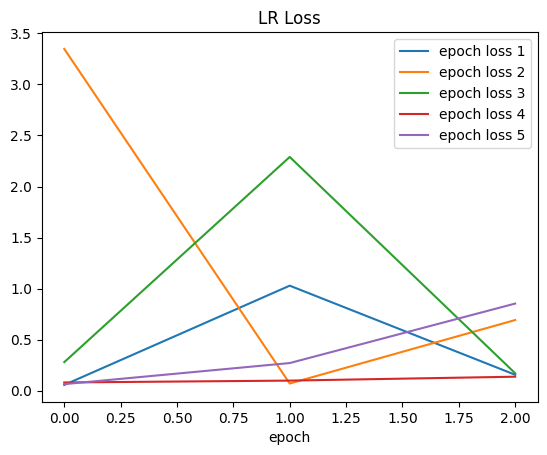

In [313]:
plt.plot(loss_list[0], label='epoch loss 1')
plt.plot(loss_list[1], label='epoch loss 2')
plt.plot(loss_list[2], label='epoch loss 3')
plt.plot(loss_list[3], label='epoch loss 4')
plt.plot(loss_list[4], label='epoch loss 5')
plt.xlabel('epoch')
plt.title('LR Loss')
plt.legend()
plt.show()

In [269]:
# test_sampler = SubsetRandomSampler(valid_index)
# # test_dataloader = DataLoader(train, batch_size=None, shuffle=False, sampler=valid_sampler)
# # from torch.autograd import Variable
# test_dataloader = DataLoader(test, batch_size=None, shuffle=False, sampler=None)
# test
Y_pred = []
Y_true = []
with torch.no_grad():
    for data, target in test:
        
        # print(data)
        # print(target)
        
        y_predict = model(torch.nan_to_num(data))
        #prediction = model(data).softmax(1).argmax()
        # prediction = torch.argmax(model(data).softmax(1), dim=1)
        #print(prediction)
        Y_pred.append(y_predict.numpy())
        #print(Y_pred)
        Y_true.append(target.numpy())
    
    
Y_pred = np.concatenate(Y_pred, axis=0)
Y_true = np.concatenate(Y_true, axis=0)

In [294]:
print(Y_pred[50:100])

[2.44240811e-042 2.98648969e-041 7.45425533e-043 7.04132267e-043
 1.57373457e-064 4.37922516e-044 2.62778666e-041 5.40128702e-043
 1.82588601e-039 2.38521535e-067 3.50431339e-093 6.41739766e-052
 1.44031745e-052 7.06943728e-050 8.94030885e-092 2.45884963e-059
 2.85894802e-032 1.08826709e-081 1.34888644e-070 9.07642761e-040
 6.83432824e-034 3.56709547e-030 1.94721761e-056 3.76127628e-043
 1.39756397e-051 5.53735265e-077 2.10733811e-024 4.76408698e-125
 1.10071414e-052 2.69026529e-043 3.86009855e-048 8.81199884e-046
 6.84610531e-049 3.03598079e-048 1.54726220e-061 2.56458961e-044
 3.72810144e-046 2.32983410e-035 2.48708647e-060 8.45100848e-046
 4.17299201e-025 2.63255953e-039 3.71256819e-049 1.19996941e-066
 6.97627381e-048 5.62571055e-042 3.12990999e-054 3.48530184e-049
 1.56220342e-069 6.73482757e-056]


In [ ]:
for i,t in enumerate(train):
    if train[i][0].shape != (1,333):
        print(i)

In [ ]:
print(train[172][0].shape)
print(test[1214][0].shape)

(1, 333)
(1, 304)


In [ ]:
for i,t in enumerate(test):
    if test[i][0].shape != (1,333):
        print(i)

1214
1339
2693
2944
3300
3567
3640
4020
4179
4241
4455
4638
